### Gradient Boosting Regression for prediction of stability in tI/2_Acetate

In [2]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv  # noqa
from scipy.stats import uniform, randint

In [3]:
# Read the data
data = pd.read_csv('/home/ta45woj/PolySpeckML/data/Ac(e)DexStabilitydata_16_09_cleaned.csv')

# Drop Rows with Non-Numeric Values in 'tI/2_Acetate' Column
data['tI/2_Acetate'] = pd.to_numeric(data['tI/2_Acetate'], errors='coerce')
data = data.dropna(subset=['tI/2_Acetate'])

In [19]:
# Extract the features 
X = data[['DS_acycl', 'DS_cycl']]

# Extract the target variable
y = data['tI/2_Acetate']


# Initialize LOOCV (leave-one-out cross-validation)
loo = LeaveOneOut()

# Define the number of seeds to use
num_seeds = 10
seeds = range(10, 10 + num_seeds)

# List to store mean MAE for each seed
mean_maes = []

# Dictionary to store all predictions for each test instance
all_predictions = {i: [] for i in range(len(y))}

for seed in seeds:
    actual_values = []
    predicted_values = []
    mae_list = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model with the current seed
        model = GradientBoostingRegressor(n_estimators=25, learning_rate=0.1, max_depth=3, random_state=seed)
        model.fit(X_train, y_train)
        
        # Predict the test set
        y_pred = model.predict(X_test)
        
        actual_value = y_test.values[0]
        predicted_value = y_pred[0]
        
        actual_values.append(actual_value)
        predicted_values.append(predicted_value)
        
        # Store the prediction for standard deviation calculation
        all_predictions[test_index[0]].append(predicted_value)
        
        # Calculate MAE for the current test sample
        mae = mean_absolute_error([actual_value], [predicted_value])
        mae_list.append(mae)

    # Calculate the mean of all MAEs for this seed
    mean_mae = np.mean(mae_list)
    mean_maes.append(mean_mae)

# Calculate overall mean and standard deviation of MAEs
overall_mean_mae = np.mean(mean_maes)
overall_std_mae = np.std(mean_maes)

# Calculate the standard deviation of predictions for each test instance
std_devs = [np.std(all_predictions[i]) for i in range(len(y))]

# Print overall MAE and its standard deviation
print(f"Mean Absolute Error (MAE): {overall_mean_mae:.4f} ± {overall_std_mae:.4f}")

Mean Absolute Error (MAE): 2.0533 ± 0.0173


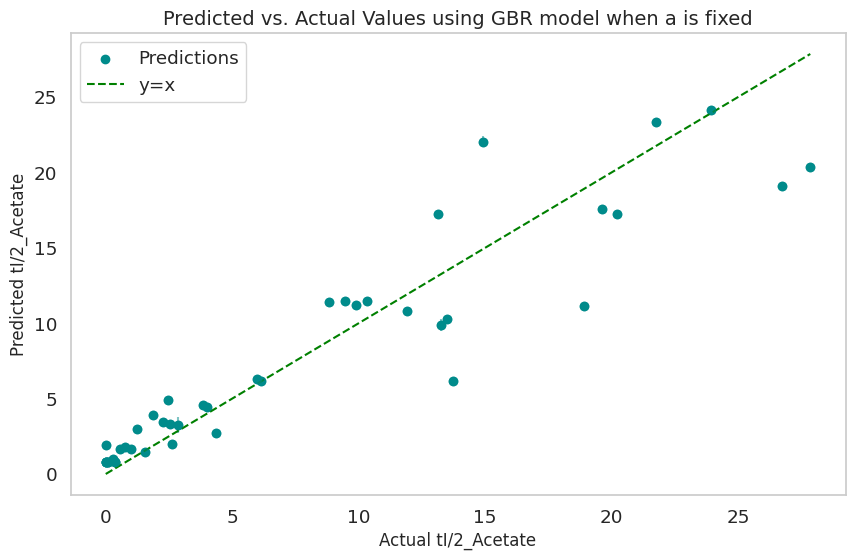

In [20]:
# Create the scatter plot using the last seed's results
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='darkcyan', label='Predictions')

# Add error bars representing the standard deviation of predictions
plt.errorbar(actual_values, predicted_values, yerr=std_devs, fmt='o', color='darkcyan', alpha=0.5)

# Add the diagonal line (perfect prediction)
min_value = min(min(actual_values), min(predicted_values))
max_value = max(max(actual_values), max(predicted_values))
plt.plot([min_value, max_value], [min_value, max_value], 'g--', label='y=x')

# Update layout
plt.title(f'Predicted vs. Actual Values using GBR model when a is fixed', fontsize=14)
plt.xlabel('Actual tI/2_Acetate', fontsize=12)
plt.ylabel('Predicted tI/2_Acetate', fontsize=12)
plt.legend()
plt.grid(False)  # Remove grid lines
plt.show()

### Hyperparameter tuning 

In [17]:
# Extract the features
X = data[['DS_acycl', 'DS_cycl']]
# Extract the target variable
y = data['tI/2_Acetate']
# Initialize LOOCV (leave-one-out cross-validation)
loo = LeaveOneOut()
# Define the number of seeds to use
num_seeds = 10
seeds = range(10, 10 + num_seeds)
# List to store mean MAE for each seed
mean_maes = []
# Dictionary to store all predictions for each test instance
all_predictions = {i: [] for i in range(len(y))}

# Variable to store the best parameters
best_params = None

for seed in seeds:
    actual_values = []
    predicted_values = []
    mae_list = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Define the hyperparameter distributions
        param_distributions = {
            'n_estimators': randint(10, 51),
            'learning_rate': uniform(0.05, 0.21),
            'max_depth': randint(2, 6),
        }
        # Create the model
        model = GradientBoostingRegressor(random_state=seed)
        # Create the RandomizedSearchCV object
        search = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='neg_mean_absolute_error',
            cv=5,
            random_state=seed,
            n_jobs=-1
        )
        # Fit the model with hyperparameter optimization
        search.fit(X_train, y_train)
        # Get the best model
        best_model = search.best_estimator_
        # Store the best parameters (we'll use the last seed's best parameters)
        best_params = search.best_params_
        # Predict the test set
        y_pred = best_model.predict(X_test)
        actual_value = y_test.values[0]
        predicted_value = y_pred[0]
        actual_values.append(actual_value)
        predicted_values.append(predicted_value)
        # Store the prediction for standard deviation calculation
        all_predictions[test_index[0]].append(predicted_value)
        # Calculate MAE for the current test sample
        mae = mean_absolute_error([actual_value], [predicted_value])
        mae_list.append(mae)
    # Calculate the mean of all MAEs for this seed
    mean_mae = np.mean(mae_list)
    mean_maes.append(mean_mae)

# Calculate overall mean and standard deviation of MAEs
overall_mean_mae = np.mean(mean_maes)
overall_std_mae = np.std(mean_maes)
# Calculate the standard deviation of predictions for each test instance
std_devs = [np.std(all_predictions[i]) for i in range(len(y))]
# Print overall MAE and its standard deviation
print(f"Mean Absolute Error (MAE): {overall_mean_mae:.4f} ± {overall_std_mae:.4f}")

# Print the best parameters
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Mean Absolute Error (MAE): 1.9542 ± 0.1350

Best Parameters:
learning_rate: 0.16456759118193748
max_depth: 5
n_estimators: 19


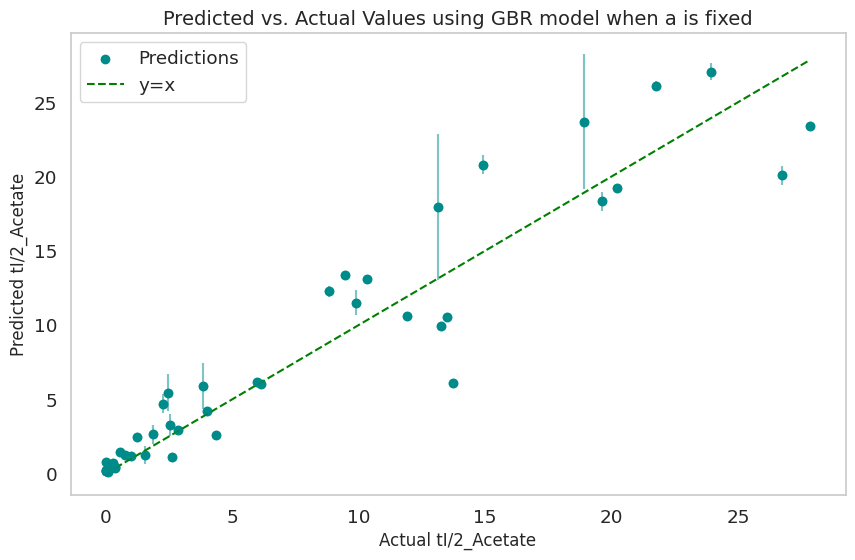

In [18]:
# Create the scatter plot using the last seed's results
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='darkcyan', label='Predictions')

# Add error bars representing the standard deviation of predictions
plt.errorbar(actual_values, predicted_values, yerr=std_devs, fmt='o', color='darkcyan', alpha=0.5)

# Add the diagonal line (perfect prediction)
min_value = min(min(actual_values), min(predicted_values))
max_value = max(max(actual_values), max(predicted_values))
plt.plot([min_value, max_value], [min_value, max_value], 'g--', label='y=x')

# Update layout
plt.title(f'Predicted vs. Actual Values using GBR model when a is fixed', fontsize=14)
plt.xlabel('Actual tI/2_Acetate', fontsize=12)
plt.ylabel('Predicted tI/2_Acetate', fontsize=12)
plt.legend()
plt.grid(False)  # Remove grid lines
plt.show()

### Heatmap for the predictions of tI/2_Acetate when defined ranges of acyclic and cyclic features

/home/ta45woj/miniconda3/envs/polyspeck/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


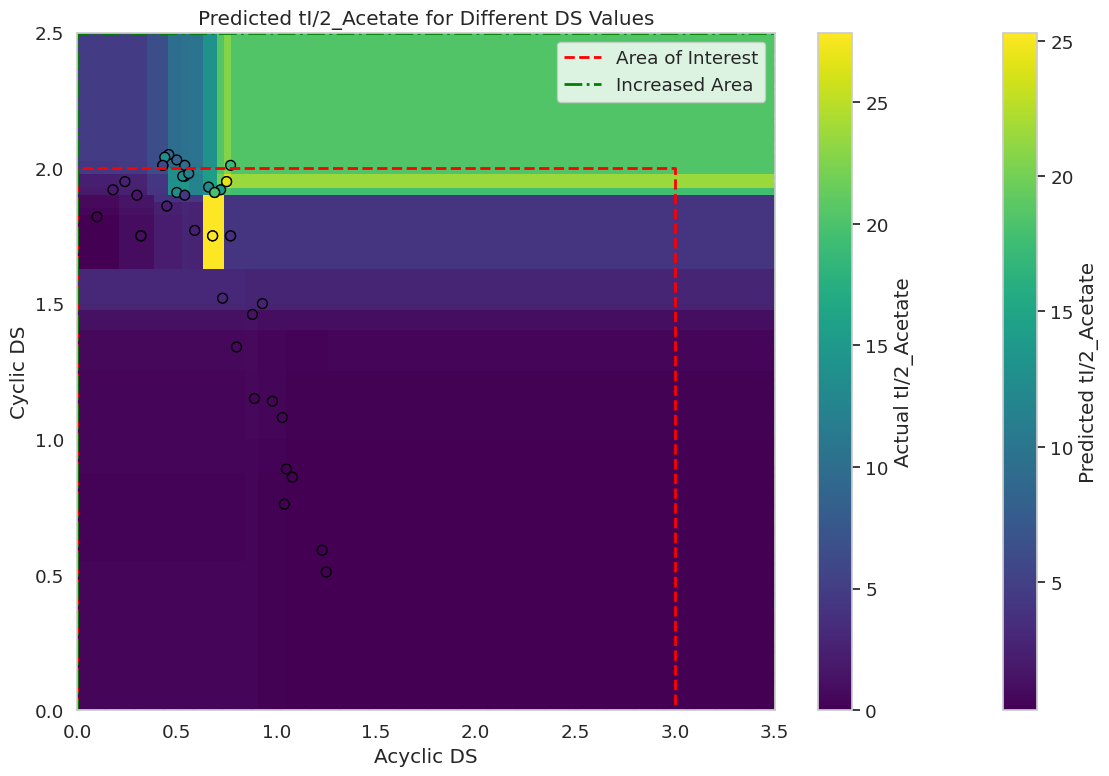

In [28]:
# Read and clean the data
data = pd.read_csv('/home/ta45woj/PolySpeckML/data/Ac(e)DexStabilitydata_16_09_cleaned.csv')
data['tI/2_Acetate'] = pd.to_numeric(data['tI/2_Acetate'], errors='coerce')
data = data.dropna(subset=['tI/2_Acetate'])

# Extract features and target
X = data[['DS_acycl', 'DS_cycl']]
y = data['tI/2_Acetate']

# Train the model on the entire dataset
model = GradientBoostingRegressor(n_estimators=19, learning_rate=0.1645, max_depth=5, random_state=42)
model.fit(X, y)

# Create a grid of points
acyclic_ds = np.linspace(0, 3.5, 100)
cyclic_ds = np.linspace(0, 2.5, 100)
xx, yy = np.meshgrid(acyclic_ds, cyclic_ds)

# Predict tI/2_Acetate for each point
grid_points = np.c_[xx.ravel(), yy.ravel()]
z = model.predict(grid_points).reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))
plt.imshow(z, extent=[0, 3.5, 0, 2.5], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted tI/2_Acetate')
plt.xlabel('Acyclic DS')
plt.ylabel('Cyclic DS')
plt.title('Predicted tI/2_Acetate for Different DS Values')

# Plot the original data points
scatter = plt.scatter(X['DS_acycl'], X['DS_cycl'], c=y, cmap='viridis', edgecolor='black', linewidth=1, s=50)
plt.colorbar(scatter, label='Actual tI/2_Acetate')

# Highlight the area of interest (typical values)
plt.plot([0, 3, 3, 0, 0], [0, 0, 2, 2, 0], 'r--', linewidth=2, label='Area of Interest')

# Highlight the increased area
plt.plot([0, 3.5, 3.5, 0, 0], [0, 0, 2.5, 2.5, 0], 'g-.', linewidth=2, label='Increased Area')

plt.legend()
plt.tight_layout()
plt.grid(False)  # Remove grid lines
plt.show()

### Logistic regression (classification) for prediction of stability in tI/2_PBS

In [3]:
# load data
data = pd.read_csv('/home/ta45woj/PolySpeckML/data/Ac(e)DexStabilitydata_16_09_cleaned.csv')

In [4]:
# Extract the relevant columns
X = data[['DS_acycl', 'DS_cycl']]

y = data['tI/2_PBS']

# Initialize LOOCV
loo = LeaveOneOut()

# Perform LOOCV and store results
actual_values = []
predicted_values = []
accuracy_list = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = model.predict(X_test)
    
    actual_value = y_test.values[0]
    predicted_value = y_pred[0]
    
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)
    
    # Calculate accuracy for the current test sample
    accuracy = accuracy_score([actual_value], [predicted_value])
    accuracy_list.append(accuracy)

# Calculate the mean of all accuracies
mean_accuracy = np.mean(accuracy_list)

print(f"Mean Accuracy: {mean_accuracy:.4f}")

# Generate classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(actual_values, predicted_values))

print("\nConfusion Matrix:")
cm = confusion_matrix(actual_values, predicted_values)
print(cm)

Mean Accuracy: 0.7907

Classification Report:
              precision    recall  f1-score   support

      stable       0.77      0.92      0.84        26
    unstable       0.83      0.59      0.69        17

    accuracy                           0.79        43
   macro avg       0.80      0.76      0.77        43
weighted avg       0.80      0.79      0.78        43


Confusion Matrix:
[[24  2]
 [ 7 10]]


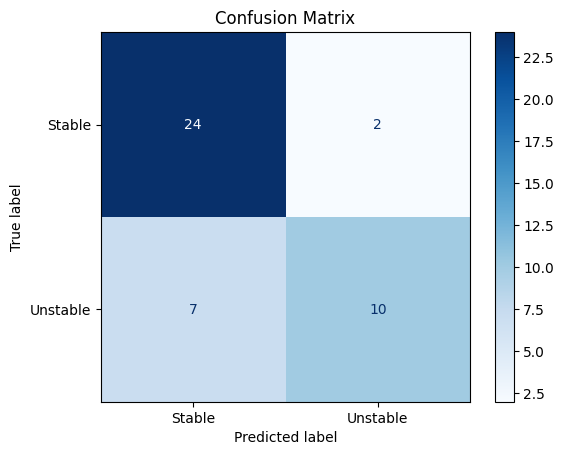

In [5]:
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Unstable'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()